In [1]:
import time

import numpy as np

from scipy import special, integrate

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

import sympy

import regions

Might need to do some analytic calculations...

In [2]:
oo = sympy.oo

In [3]:
R, Ie, Re, n, bn, R1 = sympy.symbols('R, I_e, R_e, n, b_n, R_1', real=True, positive=True)
for s in 'R, Ie, Re, n, bn, R1'.split(', '):
    globals()[s + '_symbol'] = globals()[s] # we might overwrite this later accidentally...
n_symbol

n

In [4]:
sersic = Ie * sympy.exp(-bn*((R/Re)**(1/n)-1))
sersic

I_e*exp(-b_n*((R/R_e)**(1/n) - 1))

Start by plotting the sersic fomula up to scope out where the integral might be tractible:

In [5]:
ICOEFFS = [2, -1/3, 4/405, 46/25515, 131/1148175, -2194697/30690717750]
def f_bn(n):
    """
    Ciotti and Bertin 99, valid for n >~ 0.36
    """
    return np.sum([C*n**(1-i) for i, C in enumerate(ICOEFFS)], axis=0)

def sersic_profile(R, Ie, Re, n):
    bn = f_bn(n)
    return Ie * np.exp(-bn*((R/Re)**(1/n)-1))

def log_sersic_profile(R, Ie, Re, n):
    bn = f_bn(n)
    return np.log(Ie) - bn*((R/Re)**(1/n)-1)

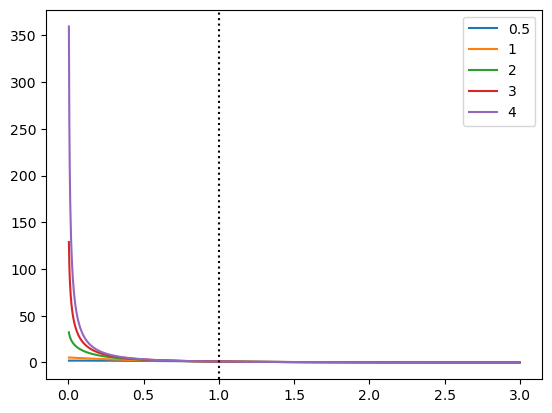

In [6]:
r = np.linspace(0, 3, 1025)[1:]
for ni in [.5, 1, 2, 3, 4]:
    plt.plot(r, sersic_profile(r, 1, 1, ni), label=ni)
plt.legend(loc=0)
plt.axvline(1, c= 'k', ls=':')

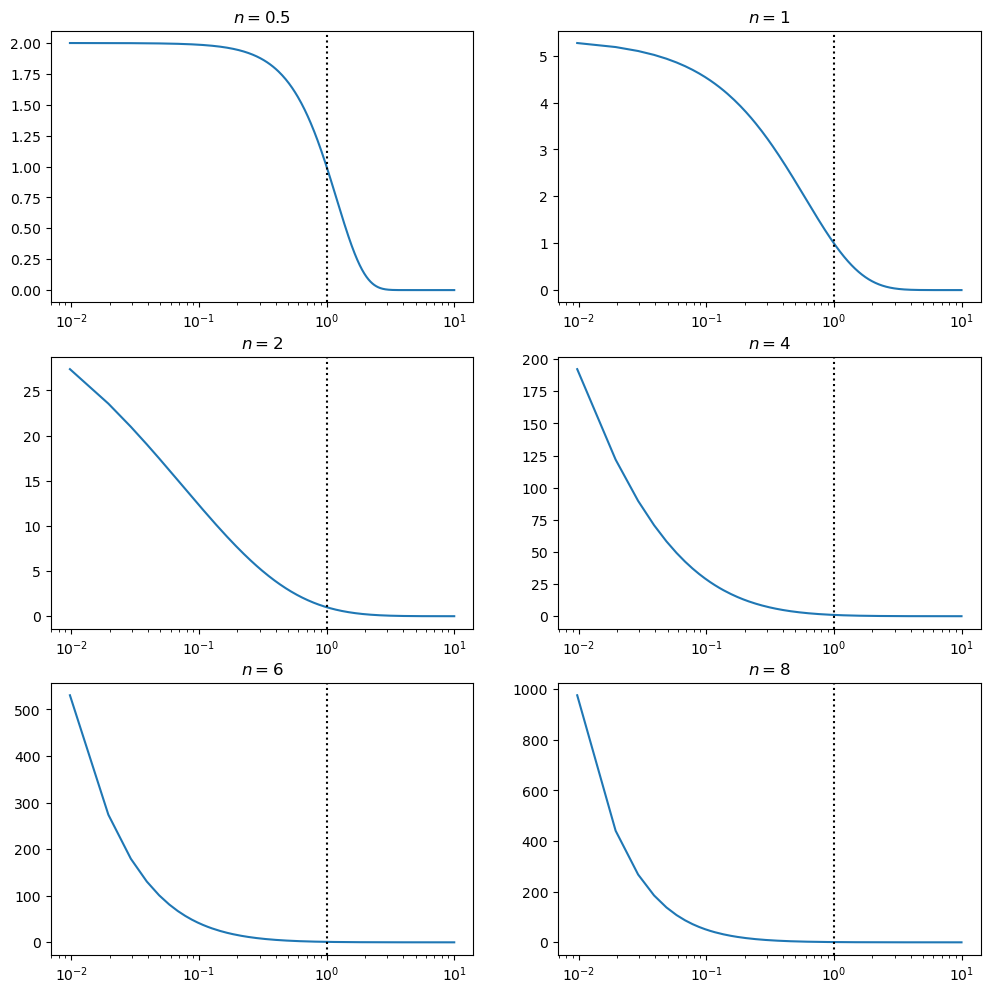

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
r = np.linspace(0, 10, 1025)[1:]
for ax, ni in zip(axs.ravel(), [.5, 1, 2, 4, 6, 8]):
    ax.semilogx(r, sersic_profile(r, 1, 1, ni))
    ax.set_title(f'$n={ni}$')
    ax.axvline(1, c= 'k', ls=':')

Now lets see how the integrand behaves since what we really need is to integrate R*I dr:

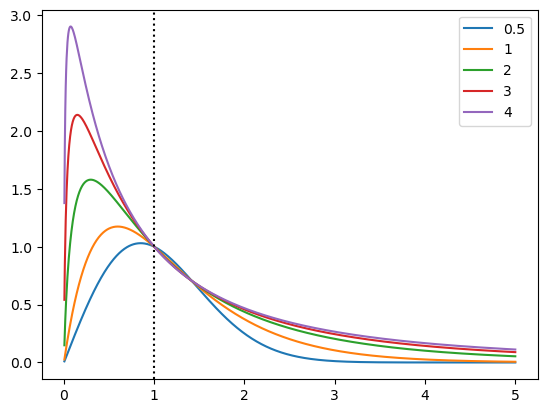

In [8]:
r = np.linspace(0, 5, 1025)[1:]
for ni in [.5, 1, 2, 3, 4]:
    plt.plot(r, r*sersic_profile(r, 1, 1, ni), label=ni)
plt.legend(loc=0)
plt.axvline(1, c= 'k', ls=':')

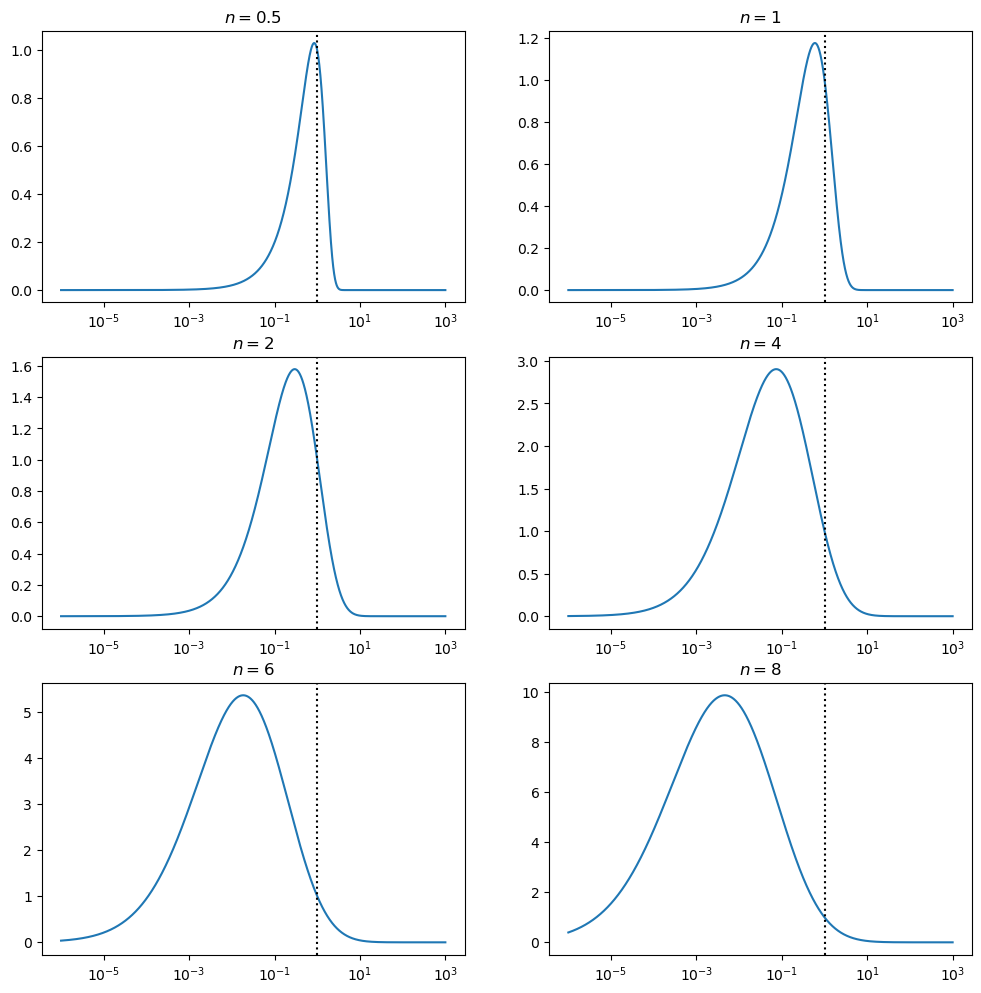

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
r = np.logspace(-6, 3, 1024*4 + 1)[1:]
for ax, ni in zip(axs.ravel(), [.5, 1, 2, 4, 6, 8]):
    ax.semilogx(r, r*sersic_profile(r, 1, 1, ni))
    ax.set_title(f'$n={ni}$')
    ax.axvline(1, c= 'k', ls=':')

Ok, so the integrand is dominated by the peak and out to ~0.4-2 orders of magnitude above/below it

Can we analytically work out the peak by solving where the derivative is 0?

In [10]:
solns = sympy.solve(sympy.diff(R*sersic, R), R)
assert len(solns)==1
solns[0]

R_e*(n/b_n)**n

Well that's shockingly straightfoward...

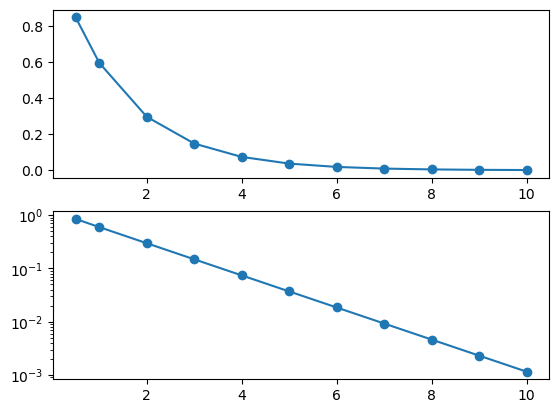

In [11]:
def integral_peak(Re, n):
    bn = f_bn(n)
    return Re*(n/bn)**n

test_ns = np.array([.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
peaks = integral_peak(1, test_ns)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(test_ns, peaks, '-o')
ax2.semilogy(test_ns, peaks, '-o')

Analytical solutions for the circular integral?

In [12]:
infintegral = sympy.integrate(R*sersic*2*sympy.pi, (R,0, oo))
infintegral

2*pi*I_e*R_e**(1/n)*n*(b_n/R_e**(1/n))**(1 - 2*n)*exp(b_n)*gamma(2*n)/b_n

In [13]:
defintegral = sympy.integrate(R*sersic*2*sympy.pi, (R,0, R1))
defintegral

4*pi*I_e*R_e**2*n**2*exp(b_n)*gamma(2*n)*lowergamma(2*n, R_1**(1/n)*b_n/R_e**(1/n))/(b_n**(2*n)*gamma(2*n + 1))

Implement this integral as a optimized scipy/numpy-compatible numerical version:

In [14]:
def sersic_integral(Router, Re, n):
    bnval = f_bn(n)
    numer1 = 4 * np.pi * Re * Re * bnval**(-2*n) * n*n * np.exp(bnval)
    
    # non-trivial thing here: the scipy gammainc is a *regularized* gamma function meaning it has a factor of 1/gamma(s), 
    # so we square our prefactor to have scipy's gammainc match the sympy definition which is not regularized
    numer2 = special.gamma(2*n)**2 * special.gammainc(2*n, Router**(1/n) * Re**(-1/n) * bnval)
    
    denom = special.gamma(2*n + 1)

    return numer1 * numer2 / denom

Confirm that it matches the sympy derivation for some test values, allowing for some rounding since sympy's engine isn't quite the same:

In [15]:
Ro_val = 3.5
Re_val = 1.2
n_val = 1.45

scipy_val = sersic_integral(Ro_val, Re_val, n_val)
subs = {Re:Re_val, n:n_val, R1:Ro_val, bn: f_bn(n_val)}
sympy_val = (defintegral/Ie).evalf(subs=subs)

np.testing.assert_allclose(scipy_val, float(sympy_val))
scipy_val, sympy_val

(np.float64(18.511837117988364), 18.5118371179884)

## Preliminaries

Now we need to try to work out a numerical solution of the integral for weird-shaped observing areas. We will try a few different approaches.  Set up some common bits for each:

In [16]:
n_fid = 3.05
Re_fid = 1.02
Ie_fid = 1

infintegral.evalf(subs={n:n_fid, Ie:Ie_fid, Re: Re_fid, bn: f_bn(n_fid)}), defintegral.evalf(subs={n:n_fid, Ie:Ie_fid, Re: Re_fid, bn: f_bn(n_fid), R1:6})

(20.7039210088726, 19.4521909907929)

In [17]:
# PARAMS: survey
survey_lowerx = -2
survey_upperx = 2
survey_lowery = -2
survey_uppery1 = 2
survey_uppery2 = 10

(-2.1, 11.1)

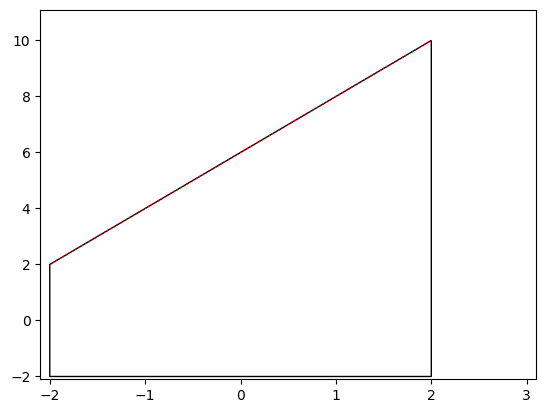

In [18]:
survey_region = regions.PolygonPixelRegion(regions.PixCoord(x=[survey_lowerx, survey_lowerx, survey_upperx, survey_upperx], y=[survey_lowery, survey_uppery1, survey_uppery2, survey_lowery]))

survey_region.plot()

x = np.linspace(survey_lowerx, survey_upperx, 10)
def survey_upper_line_y(x):
    return 2*x+6
plt.plot(x, survey_upper_line_y(x), ':', c='r', lw=1)

plt.xlim(survey_region.bounding_box.ixmin-.1, survey_region.bounding_box.ixmax+.1)
plt.ylim(survey_region.bounding_box.iymin-.1, survey_region.bounding_box.iymax+.1)

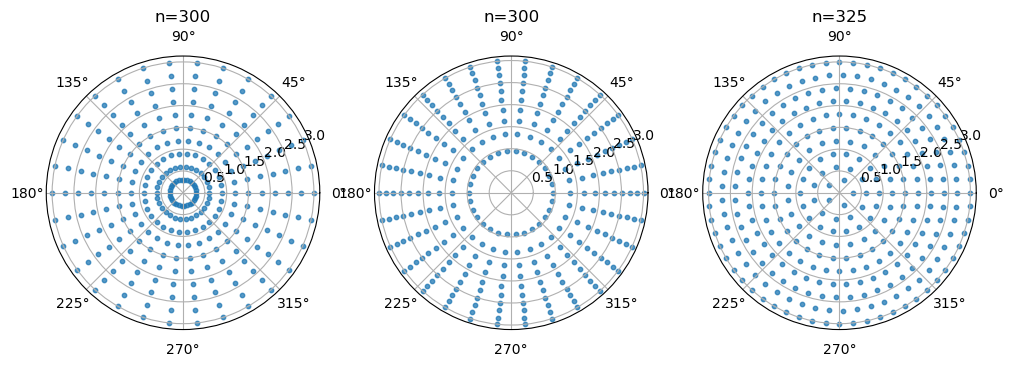

In [19]:
def make_r_grid(nr, nphi, outerr):
    phi = np.arange(nphi)*2*np.pi/nphi
    r = np.linspace(0, outerr, nr+1)[1:]
    
    return np.meshgrid(r, phi)

def make_r_grid_rweighted(nr, nphi, outerr):
    phi = np.arange(nphi)*2*np.pi/nphi
    u = np.linspace(0, 1, nr+1)[1:]
    r = np.sqrt(u)*outerr
    
    return np.meshgrid(r, phi)

# we use nphiouterhalf because that makes the total number reasonably close to the above 2
def make_r_grid_phiweighted(nr, nphiouterhalf, outerr):
    r = np.linspace(0, outerr, nr+1)[1:]
    rs = []
    phis = []
    for ri in r:
        nphi = int(ri/outerr * nphiouterhalf*2)
        phi = np.linspace(0, 2*np.pi, nphi+1)[:-1]
        rs.append(np.full_like(phi, ri))
        phis.append(phi)
    
    return np.concatenate(rs), np.concatenate(phis)

gridfuncs = [make_r_grid, make_r_grid_rweighted, make_r_grid_phiweighted]

fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(12, 6))
for ax, f in zip(axs.ravel(), gridfuncs):
    fres = f(10, 30, 3)
    ax.scatter(*[c.ravel() for c in fres][::-1], s=10, alpha=.75)
    ax.set_title(f'n={len(fres[0].ravel())}')
None

In [20]:
def grid_in_region(r, phi, region, invert=False):
    x, y = r*np.cos(phi), r*np.sin(phi)
    msk = region.contains(regions.PixCoord(x=x, y=y))
    if invert:
        return r[~msk], phi[~msk], msk
    else:
        return r[msk], phi[msk], msk

## Technique 1: direct integration

This will be too slow but is an arbitrary-precision check to ensure accuracy of the others. Does not use the region mask above so a bit more awkward, but mocks up the region above.

In [21]:
def sersic_integrand(x, y, Ie, Re, n):
    R = np.hypot(x, y)
    # don't need the R because dblquad is already over a  cartersian grid
    return sersic_profile(R, Ie, Re, n)

First do something large enough to be very close to infinity

In [22]:
infresult = integrate.dblquad(sersic_integrand, 
                  a=-200, b=200, 
                  gfun=lambda x: -200, hfun=lambda x:200,#hfun=upper_line_y, 
                  args=(Ie_fid, Re_fid, n_fid))
infresult, infintegral.evalf(subs={n:n_fid, Ie:Ie_fid, Re: Re_fid, bn: f_bn(n_fid)})

((20.703920976655795, 2.5427376387817587e-07), 20.7039210088726)

Now try a more realistic case and compare to a vaguely similar definite integral

In [23]:
directresult = integrate.dblquad(sersic_integrand, 
                  a=survey_lowerx, b=survey_upperx,
                  gfun=lambda x: survey_lowery, hfun=survey_upper_line_y, 
                  args=(Ie_fid, Re_fid, n_fid))
directresult, defintegral.evalf(subs={n:n_fid, Ie:Ie_fid, Re: Re_fid, bn: f_bn(n_fid), R1:3})

((16.07984101852088, 2.796671543617323e-07), 16.9300679559812)

Now get a ballpark time estimate

In [24]:
%%timeit 
integrate.dblquad(sersic_integrand, 
                  a=-2, b=2,
                  gfun=lambda x: -2, hfun=survey_upper_line_y, 
                  args=(Ie_fid, Re_fid, n_fid))

712 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit 
integrate.dblquad(sersic_integrand, 
                  a=-2, b=2,
                  gfun=lambda x: -2, hfun=survey_upper_line_y, 
                  args=(Ie_fid, Re_fid, n_fid),
                  epsabs=1e-4, epsrel=1e-4)

72.6 ms ± 5.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


~1 sec is way too long if we're doing this in an inner loop. 65 ms / 6e-2 sec is maybe doable? It at least gives a benchmark.  Although expressing the selection mask is *much* harder this way for anything other than this toy problem.

## Technique 2: Direct grid evaluation

Compute the grid values and integrate numerically on the grid

In [26]:
def sersic_integral_direct_grid(nr, nphi, Ie=Ie_fid, Re=Re_fid, n=n_fid, region=survey_region):
    outerr = np.max(np.abs(region.bounding_box.extent))
    r, phi = make_r_grid(nr, nphi, outerr)
    dr = np.diff(r, axis=1).mean()
    dphi = np.diff(phi, axis=0).mean()
    rg, phig, msk = grid_in_region(r, phi, region)
    I = sersic_profile(rg, Ie, Re, n)

    sum = np.sum(I*rg)
    return sum*(dr*dphi*sum.size)

res = sersic_integral_direct_grid(100, 100)

# result, correct result, relative error
float(res), directresult[0], (float(res)-directresult[0])/directresult[0]

(15.68654653395706, 16.07984101852088, -0.024458854046555657)

In [27]:
def sersic_integral_direct_grid_rweighted(nr, nphi, Ie=Ie_fid, Re=Re_fid, n=n_fid, region=survey_region):
    outerr = np.max(np.abs(region.bounding_box.extent))
    r, phi = make_r_grid_rweighted(nr, nphi, outerr)
    rg, phig, msk = grid_in_region(r, phi, survey_region)

    I = sersic_profile(rg, Ie, Re, n)

    # because the grid is constructed to make every point ~ equal area, it is just a fixed factor per interior grid point
    dA = np.pi*outerr**2 / r.size

    return np.sum(I*dA)

res = sersic_integral_direct_grid_rweighted(10000, 100)

# result, correct result, relative error
float(res), directresult[0], (float(res)-directresult[0])/directresult[0]

(15.337451570457262, 16.07984101852088, -0.04616895448210773)

Why don't those agree?? Might be because the integral is busiest where the r is least-weighted?  If so this is definitely a bad method.

In [28]:
def sersic_integral_direct_grid_phiweighted(nr, nphiouterhalf, Ie=Ie_fid, Re=Re_fid, n=n_fid, region=survey_region):
    outerr = np.max(np.abs(region.bounding_box.extent))
    r, phi = make_r_grid_phiweighted(nr, nphiouterhalf, outerr)

    rg, phig, msk = grid_in_region(r, phi, survey_region)


    I = sersic_profile(rg, Ie, Re, n)

    # because the grid is constructed to make every point ~ equal area, it is just a fixed factor per interior grid point
    dA = np.pi*outerr**2 / r.size

    return np.sum(I*dA)

res = sersic_integral_direct_grid_phiweighted(100, 100)

# result, correct result, relative error
float(res), directresult[0], (float(res)-directresult[0])/directresult[0]

(15.519989082296268, 16.07984101852088, -0.0348170069330767)

Now need to try over different grid sizes and see what converges fastest

In [29]:
nrnphi_to_try = [(10,30),(30, 10), (10, 100), (100, 10), (100, 100), (500, 100), (100, 500), (1000, 1000), (500, 10), (1000, 10), (1000, 100)]
timing_repeats = 10

#### equal r/phi spacing

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 3.60e-04 +/- 1.55e-04, frac: 42.991%
(30, 10) t 3.68e-04 +/- 6.51e-05, frac: 17.693%
(10, 100) t 4.83e-04 +/- 1.90e-04, frac: 39.254%
(100, 10) t 4.89e-04 +/- 2.74e-05, frac: 5.609%
(100, 100) t 2.48e-03 +/- 5.79e-04, frac: 23.343%
(500, 100) t 6.34e-03 +/- 1.53e-04, frac: 2.418%
(100, 500) t 6.36e-03 +/- 1.41e-04, frac: 2.211%
(1000, 1000) t 1.39e-01 +/- 2.19e-03, frac: 1.578%
(500, 10) t 6.80e-04 +/- 4.04e-05, frac: 5.942%
(1000, 10) t 1.30e-03 +/- 3.85e-05, frac: 2.946%
(1000, 100) t 1.28e-02 +/- 2.49e-04, frac: 1.946%
(10, 30) Ideviation: -42.731%
(30, 10) Ideviation: -12.349%
(10, 100) Ideviation: -42.811%
(100, 10) Ideviation: -2.331%
(100, 100) Ideviation: -2.446%
(500, 100) Ideviation: -0.215%
(100, 500) Ideviation: -2.518%
(1000, 1000) Ideviation: -0.063%
(500, 10) Ideviation: -0.217%
(1000, 10) Ideviation: -0.092%
(1000, 100) Ideviation: -0.075%


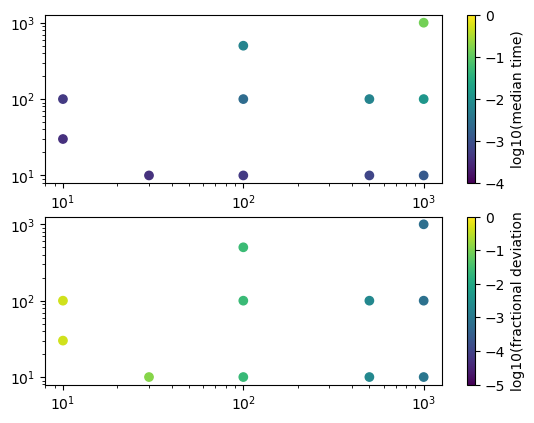

In [30]:
times = []
medtimes = []
stdtimes = []
results = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()
        reses.append(sersic_integral_direct_grid(nr, nphi))
        t2 = time.time()
        ts.append(t2-t1)
    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-5, vmax=0)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()

for nl, t, s in zip(nrnphi_to_try, medtimes, stdtimes):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}')

for nl, f in zip(nrnphi_to_try, fracdev):
    print(nl, 'Ideviation:', f'{f:.3%}')
    

We can get to ~1e-3 precision in more like 1ms, which is more the target ballpark.

#### r weighted

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 1.32e-04 +/- 6.42e-05, frac: 48.622%
(30, 10) t 1.44e-04 +/- 1.81e-05, frac: 12.560%
(10, 100) t 2.30e-04 +/- 1.13e-04, frac: 49.087%
(100, 10) t 1.71e-04 +/- 2.09e-05, frac: 12.208%
(100, 100) t 1.30e-03 +/- 6.05e-05, frac: 4.654%
(500, 100) t 6.57e-03 +/- 2.31e-04, frac: 3.510%
(100, 500) t 6.39e-03 +/- 8.91e-05, frac: 1.395%
(1000, 1000) t 1.36e-01 +/- 3.32e-03, frac: 2.435%
(500, 10) t 6.71e-04 +/- 3.05e-05, frac: 4.537%
(1000, 10) t 1.30e-03 +/- 4.28e-05, frac: 3.291%
(1000, 100) t 1.26e-02 +/- 3.11e-04, frac: 2.464%
(10, 30) Ideviation: -96.88%
(30, 10) Ideviation: -77.21%
(10, 100) Ideviation: -96.68%
(100, 10) Ideviation: -53.61%
(100, 100) Ideviation: -53.90%
(500, 100) Ideviation: -26.95%
(100, 500) Ideviation: -54.07%
(1000, 1000) Ideviation: -18.88%
(500, 10) Ideviation: -26.94%
(1000, 10) Ideviation: -18.86%
(1000, 100) Ideviation: -18.88%


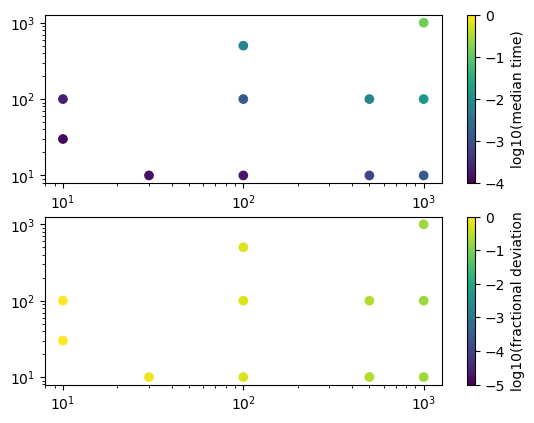

In [31]:
times = []
medtimes = []
stdtimes = []
results = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()
        reses.append(sersic_integral_direct_grid_rweighted(nr, nphi))
        t2 = time.time()
        ts.append(t2-t1)
    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-5, vmax=0)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()

for nl, t, s in zip(nrnphi_to_try, medtimes, stdtimes):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}')

for nl, f in zip(nrnphi_to_try, fracdev):
    print(nl, 'Ideviation:', f'{f:.2%}')
    

#### phi weighted

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 2.23e-04 +/- 1.19e-04, frac: 53.366%
(30, 10) t 4.17e-04 +/- 6.69e-05, frac: 16.021%
(10, 100) t 3.23e-04 +/- 2.18e-04, frac: 67.491%
(100, 10) t 9.04e-04 +/- 2.83e-04, frac: 31.252%
(100, 100) t 2.44e-03 +/- 2.17e-04, frac: 8.906%
(500, 100) t 9.74e-03 +/- 5.85e-04, frac: 6.009%
(100, 500) t 7.99e-03 +/- 8.50e-04, frac: 10.636%
(1000, 1000) t 1.45e-01 +/- 6.22e-03, frac: 4.288%
(500, 10) t 3.29e-03 +/- 6.84e-05, frac: 2.080%
(1000, 10) t 6.72e-03 +/- 5.84e-05, frac: 0.870%
(1000, 100) t 1.90e-02 +/- 7.88e-04, frac: 4.142%
(10, 30) Ideviation: -47.64%
(30, 10) Ideviation: -56.33%
(10, 100) Ideviation: -47.15%
(100, 10) Ideviation: -46.97%
(100, 100) Ideviation: -3.48%
(500, 100) Ideviation: -7.36%
(100, 500) Ideviation: -3.51%
(1000, 1000) Ideviation: -0.18%
(500, 10) Ideviation: -50.50%
(1000, 10) Ideviation: -50.92%
(1000, 100) Ideviation: -7.00%


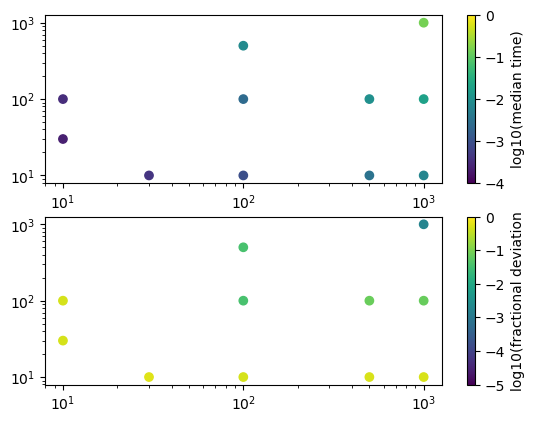

In [32]:
times = []
medtimes = []
stdtimes = []
results = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()
        reses.append(sersic_integral_direct_grid_phiweighted(nr, nphi))
        t2 = time.time()
        ts.append(t2-t1)
    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-5, vmax=0)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()


for nl, t, s in zip(nrnphi_to_try, medtimes, stdtimes):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}')

for nl, f in zip(nrnphi_to_try, fracdev):
    print(nl, 'Ideviation:', f'{f:.2%}')
    

## Technique 3: Integrate to outer edge and remove excess

Evaluate the integral to the largest point in the mask, then subtract out the parts of the radial grid that are outside

In [33]:
nr = 100
nphi = 100
region = survey_region
Re = Re_fid
n = n_fid
Ie = Ie_fid

outerr = np.max(np.abs(region.bounding_box.extent))
outer_integ = sersic_integral(outerr, Re, n)

r, phi = make_r_grid(nr, nphi, outerr)
dr = np.diff(r, axis=1).mean()
dphi = np.diff(phi, axis=0).mean()

rg, phig, msk = grid_in_region(r, phi, region, invert=True)
print('fraction in mask', np.sum(msk)/msk.size)

I = sersic_profile(rg, Ie, Re, n)

result = outer_integ - np.sum(I*rg)*dr*dphi
fracdev = (np.array(result) - directresult[0])/directresult[0]
result, fracdev


fraction in mask 0.2681


(np.float64(16.10165696502125), np.float64(0.0013567265046489098))

#### Equal spacing

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 3.50e-04 +/- 1.50e-04, frac: 42.885% Ideviation: -0.832%
(30, 10) t 1.71e-04 +/- 4.59e-05, frac: 26.862% Ideviation: 0.888%
(10, 100) t 2.83e-04 +/- 1.51e-04, frac: 53.385% Ideviation: -0.912%
(100, 10) t 3.05e-04 +/- 5.24e-05, frac: 17.156% Ideviation: 0.251%
(100, 100) t 1.48e-03 +/- 7.62e-05, frac: 5.144% Ideviation: 0.136%
(500, 100) t 7.14e-03 +/- 2.17e-04, frac: 3.040% Ideviation: -0.024%
(100, 500) t 7.18e-03 +/- 2.17e-04, frac: 3.016% Ideviation: 0.064%
(1000, 1000) t 1.43e-01 +/- 3.18e-03, frac: 2.219% Ideviation: -0.006%
(500, 10) t 7.35e-04 +/- 1.96e-04, frac: 26.599% Ideviation: -0.025%
(1000, 10) t 1.36e-03 +/- 1.70e-05, frac: 1.249% Ideviation: -0.036%
(1000, 100) t 1.36e-02 +/- 1.58e-04, frac: 1.169% Ideviation: -0.019%
(10, 30) frac in mask: 22.00%
(30, 10) frac in mask: 26.00%
(10, 100) frac in mask: 22.10%
(100, 10) frac in mask: 26.70%
(100, 100) frac in mask: 26.81%
(500, 100) frac in mask: 27.11%
(100, 500) frac in mask: 26.75%
(1000, 1000) frac in mask:

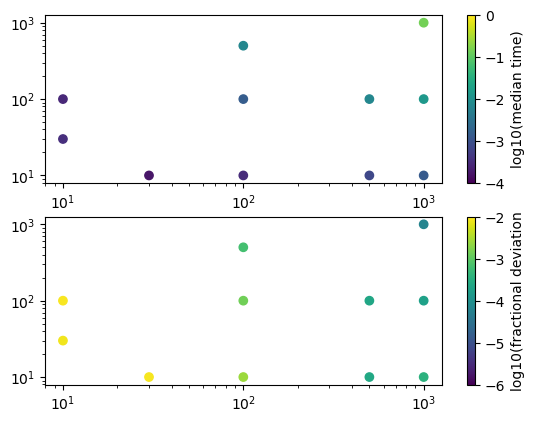

In [34]:
times = []
medtimes = []
stdtimes = []
results = []
fracinmasks = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()

        outerr = np.max(np.abs(survey_region.bounding_box.extent))
        outer_integ = sersic_integral(outerr, Re_fid, n_fid)

        r, phi = make_r_grid(nr, nphi, outerr)
        dr = np.diff(r, axis=1).mean()
        dphi = np.diff(phi, axis=0).mean()

        rg, phig, msk = grid_in_region(r, phi, survey_region, invert=True)

        I = sersic_profile(rg, Ie_fid, Re_fid, n_fid)

        result = outer_integ - np.sum(I*rg)*dr*dphi    

        t2 = time.time()

        reses.append(result)
        ts.append(t2-t1)
    fracinmasks.append(np.sum(msk)/msk.size)

    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-6, vmax=-2)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()


for nl, t, s, f in zip(nrnphi_to_try, medtimes, stdtimes, fracdev):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}', 'Ideviation:', f'{f:.3%}')

for nl, fi in zip(nrnphi_to_try, fracinmasks):
    print(nl, 'frac in mask:', f'{fi:.2%}')

#### r weighted

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 1.77e-04 +/- 1.24e-04, frac: 69.996% Ideviation: 2.698%
(30, 10) t 1.62e-04 +/- 7.05e-05, frac: 43.481% Ideviation: 1.300%
(10, 100) t 2.50e-04 +/- 1.48e-04, frac: 58.971% Ideviation: 2.894%
(100, 10) t 2.36e-04 +/- 1.19e-05, frac: 5.040% Ideviation: 0.217%
(100, 100) t 1.56e-03 +/- 1.13e-04, frac: 7.264% Ideviation: -0.070%
(500, 100) t 6.88e-03 +/- 4.00e-04, frac: 5.811% Ideviation: 0.034%
(100, 500) t 7.11e-03 +/- 3.10e-04, frac: 4.365% Ideviation: -0.243%
(1000, 1000) t 1.44e-01 +/- 6.27e-03, frac: 4.340% Ideviation: -0.006%
(500, 10) t 7.43e-04 +/- 3.27e-04, frac: 44.063% Ideviation: 0.053%
(1000, 10) t 1.38e-03 +/- 4.84e-05, frac: 3.501% Ideviation: 0.015%
(1000, 100) t 1.35e-02 +/- 3.03e-04, frac: 2.240% Ideviation: -0.006%
(10, 30) frac in mask: 4.00%
(30, 10) frac in mask: 7.33%
(10, 100) frac in mask: 4.40%
(100, 10) frac in mask: 8.40%
(100, 100) frac in mask: 8.74%
(500, 100) frac in mask: 9.17%
(100, 500) frac in mask: 8.69%
(1000, 1000) frac in mask: 9.19%
(500

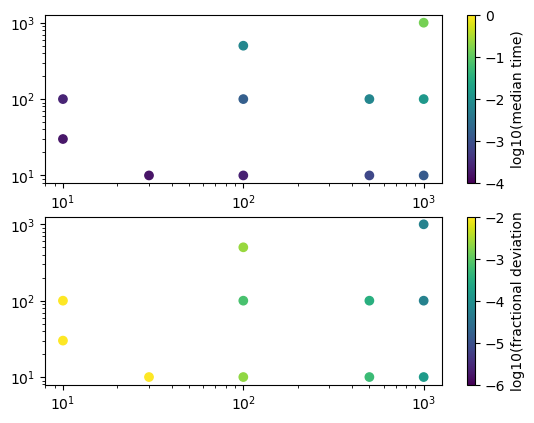

In [35]:
times = []
medtimes = []
stdtimes = []
results = []
fracinmasks = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()

        outerr = np.max(np.abs(survey_region.bounding_box.extent))
        outer_integ = sersic_integral(outerr, Re_fid, n_fid)

        r, phi = make_r_grid_rweighted(nr, nphi, outerr)
        
        rg, phig, msk = grid_in_region(r, phi, survey_region, invert=True)

        I = sersic_profile(rg, Ie_fid, Re_fid, n_fid)
    
        dA = np.pi*outerr**2 / r.size
        result = outer_integ - np.sum(I*dA)    

        t2 = time.time()

        reses.append(result)
        ts.append(t2-t1)
    fracinmasks.append(np.sum(msk)/msk.size)

    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-6, vmax=-2)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()


for nl, t, s, f in zip(nrnphi_to_try, medtimes, stdtimes, fracdev):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}', 'Ideviation:', f'{f:.3%}')

for nl, fi in zip(nrnphi_to_try, fracinmasks):
    print(nl, 'frac in mask:', f'{fi:.2%}')

#### phi weighted

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 2.88e-04 +/- 1.38e-04, frac: 47.710% Ideviation: 1.949%
(30, 10) t 5.65e-04 +/- 5.49e-04, frac: 97.137% Ideviation: 0.656%
(10, 100) t 3.95e-04 +/- 4.34e-04, frac: 110.027% Ideviation: 2.442%
(100, 10) t 1.28e-03 +/- 3.08e-04, frac: 24.111% Ideviation: -1.625%
(100, 100) t 2.45e-03 +/- 3.97e-04, frac: 16.226% Ideviation: 0.631%
(500, 100) t 1.07e-02 +/- 9.58e-04, frac: 8.986% Ideviation: 0.101%
(100, 500) t 7.50e-03 +/- 2.16e-04, frac: 2.881% Ideviation: 0.368%
(1000, 1000) t 1.52e-01 +/- 5.97e-03, frac: 3.918% Ideviation: 0.026%
(500, 10) t 3.32e-03 +/- 2.52e-04, frac: 7.581% Ideviation: -1.582%
(1000, 10) t 6.57e-03 +/- 1.54e-04, frac: 2.340% Ideviation: -1.590%
(1000, 100) t 1.97e-02 +/- 5.12e-04, frac: 2.605% Ideviation: 0.061%
(10, 30) frac in mask: 7.58%
(30, 10) frac in mask: 7.77%
(10, 100) frac in mask: 8.55%
(100, 10) frac in mask: 7.95%
(100, 100) frac in mask: 9.25%
(500, 100) frac in mask: 9.16%
(100, 500) frac in mask: 9.17%
(1000, 1000) frac in mask: 9.23%
(50

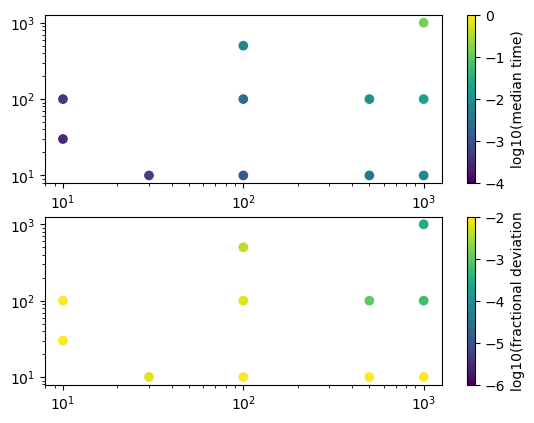

In [36]:
times = []
medtimes = []
stdtimes = []
results = []
fracinmasks = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()

        outerr = np.max(np.abs(survey_region.bounding_box.extent))
        outer_integ = sersic_integral(outerr, Re_fid, n_fid)

        r, phi = make_r_grid_phiweighted(nr, nphi, outerr)
        
        rg, phig, msk = grid_in_region(r, phi, survey_region, invert=True)

        I = sersic_profile(rg, Ie_fid, Re_fid, n_fid)
    
        dA = np.pi*outerr**2 / r.size
        result = outer_integ - np.sum(I*dA)    

        t2 = time.time()

        reses.append(result)
        ts.append(t2-t1)
    fracinmasks.append(np.sum(msk)/msk.size)

    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-6, vmax=-2)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()


for nl, t, s, f in zip(nrnphi_to_try, medtimes, stdtimes, fracdev):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}', 'Ideviation:', f'{f:.3%}')

for nl, fi in zip(nrnphi_to_try, fracinmasks):
    print(nl, 'frac in mask:', f'{fi:.2%}')

## Technique 4: Integrate to inner edge and add excess

Evaluate the integral to the smallest point in the mask, then add the parts of the radial grid that are outside the integral but inside the mask.

#### Equal spacing

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 3.62e-04 +/- 1.12e-04, frac: 31.053% Ideviation: 2.381%
(30, 10) t 1.80e-04 +/- 6.81e-05, frac: 37.919% Ideviation: 2.500%
(10, 100) t 2.88e-04 +/- 1.43e-04, frac: 49.582% Ideviation: 2.363%
(100, 10) t 2.73e-04 +/- 1.20e-05, frac: 4.407% Ideviation: 3.025%
(100, 100) t 1.48e-03 +/- 1.21e-04, frac: 8.205% Ideviation: 3.455%
(500, 100) t 6.32e-03 +/- 1.95e-04, frac: 3.080% Ideviation: 3.245%
(100, 500) t 6.31e-03 +/- 6.78e-05, frac: 1.075% Ideviation: 3.449%
(1000, 1000) t 1.33e-01 +/- 6.75e-03, frac: 5.077% Ideviation: 3.275%
(500, 10) t 6.99e-04 +/- 2.78e-04, frac: 39.857% Ideviation: 2.915%
(1000, 10) t 1.27e-03 +/- 1.76e-05, frac: 1.384% Ideviation: 2.925%
(1000, 100) t 1.23e-02 +/- 2.23e-04, frac: 1.812% Ideviation: 3.278%
(10, 30) frac in mask: 4.67%
(30, 10) frac in mask: 4.67%
(10, 100) frac in mask: 4.80%
(100, 10) frac in mask: 5.10%
(100, 100) frac in mask: 5.55%
(500, 100) frac in mask: 5.40%
(100, 500) frac in mask: 5.53%
(1000, 1000) frac in mask: 5.41%
(500, 10

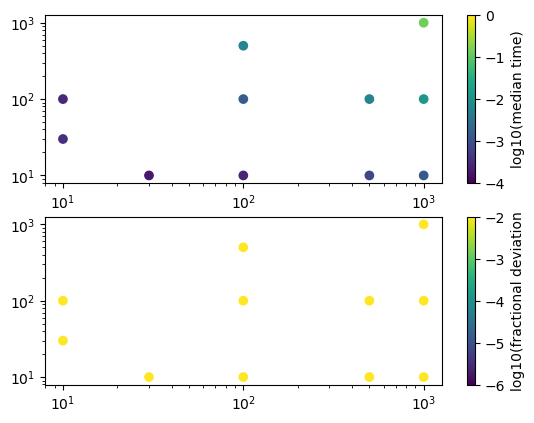

In [37]:
times = []
medtimes = []
stdtimes = []
results = []
fracinmasks = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()


        outerr = np.max(np.abs(survey_region.bounding_box.extent))
        innerr = np.min(np.abs(survey_region.bounding_box.extent))
        inner_integ = sersic_integral(innerr, Re_fid, n_fid)

        r, phi = make_r_grid(nr, nphi, outerr)
        dr = np.diff(r, axis=1).mean()
        dphi = np.diff(phi, axis=0).mean()

        _, _, msk = grid_in_region(r, phi, survey_region, invert=False)
        allmsk = msk & (r>innerr)
        rg = r[allmsk]
        phig = phi[allmsk]

        I = sersic_profile(rg, Ie_fid, Re_fid, n_fid)

        result = inner_integ + np.sum(I*rg)*dr*dphi  

        t2 = time.time()

        reses.append(result)
        ts.append(t2-t1)
    fracinmasks.append(np.sum(allmsk)/allmsk.size)

    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-6, vmax=-2)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()


for nl, t, s, f in zip(nrnphi_to_try, medtimes, stdtimes, fracdev):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}', 'Ideviation:', f'{f:.3%}')

for nl, fi in zip(nrnphi_to_try, fracinmasks):
    print(nl, 'frac in mask:', f'{fi:.2%}')

#### phi weighted

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 2.30e-04 +/- 7.58e-05, frac: 32.888% Ideviation: 2.127%
(30, 10) t 3.59e-04 +/- 5.03e-05, frac: 14.015% Ideviation: 2.902%
(10, 100) t 3.35e-04 +/- 6.45e-05, frac: 19.247% Ideviation: 2.200%
(100, 10) t 8.31e-04 +/- 7.91e-05, frac: 9.522% Ideviation: 3.048%
(100, 100) t 1.99e-03 +/- 1.41e-04, frac: 7.099% Ideviation: 3.473%
(500, 100) t 9.09e-03 +/- 1.17e-04, frac: 1.288% Ideviation: 3.208%
(100, 500) t 6.84e-03 +/- 4.84e-04, frac: 7.077% Ideviation: 3.445%
(1000, 1000) t 1.38e-01 +/- 4.51e-03, frac: 3.282% Ideviation: 3.272%
(500, 10) t 3.33e-03 +/- 2.35e-04, frac: 7.063% Ideviation: 2.919%
(1000, 10) t 6.69e-03 +/- 1.28e-04, frac: 1.909% Ideviation: 2.927%
(1000, 100) t 1.90e-02 +/- 7.92e-04, frac: 4.164% Ideviation: 3.236%
(10, 30) frac in mask: 3.03%
(30, 10) frac in mask: 4.39%
(10, 100) frac in mask: 3.91%
(100, 10) frac in mask: 4.44%
(100, 100) frac in mask: 4.50%
(500, 100) frac in mask: 4.42%
(100, 500) frac in mask: 4.47%
(1000, 1000) frac in mask: 4.45%
(500, 10)

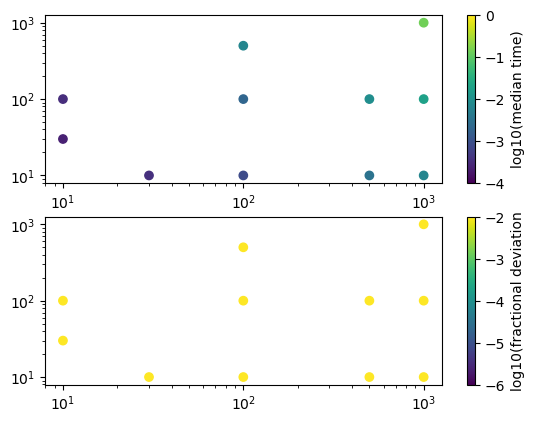

In [38]:
times = []
medtimes = []
stdtimes = []
results = []
fracinmasks = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()


        outerr = np.max(np.abs(survey_region.bounding_box.extent))
        innerr = np.min(np.abs(survey_region.bounding_box.extent))
        inner_integ = sersic_integral(innerr, Re_fid, n_fid)

        r, phi = make_r_grid_phiweighted(nr, nphi, outerr)
        
        #rg, phig, msk = grid_in_region(r, phi, survey_region, invert=True)
        _, _, msk = grid_in_region(r, phi, survey_region, invert=False)
        allmsk = msk & (r>innerr)
        rg = r[allmsk]
        phig = phi[allmsk]

        I = sersic_profile(rg, Ie_fid, Re_fid, n_fid)
    
        dA = np.pi*outerr**2 / r.size
        result = inner_integ + np.sum(I*dA)    

        # r, phi = make_r_grid(nr, nphi, outerr)
        # dr = np.diff(r, axis=1).mean()
        # dphi = np.diff(phi, axis=0).mean()

        # _, _, msk = grid_in_region(r, phi, survey_region, invert=False)
        # allmsk = msk & (r>innerr)
        # rg = r[allmsk]
        # phig = phi[allmsk]

        # I = sersic_profile(rg, Ie_fid, Re_fid, n_fid)

        # result = inner_integ + np.sum(I*rg)*dr*dphi  

        t2 = time.time()

        reses.append(result)
        ts.append(t2-t1)
    fracinmasks.append(np.sum(allmsk)/allmsk.size)

    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-6, vmax=-2)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()


for nl, t, s, f in zip(nrnphi_to_try, medtimes, stdtimes, fracdev):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}', 'Ideviation:', f'{f:.3%}')

for nl, fi in zip(nrnphi_to_try, fracinmasks):
    print(nl, 'frac in mask:', f'{fi:.2%}')

Neither of those seem to be right, but also neither seems to offer a speedup so lets not worry about it.

## Technique 5: Sample integrand points by inverse distribution, scale by outer edge

Start with technique 3, but then sample the integrand by CDF and just sum up the fraction in and out of the mask instead of evaluating the integral explicitly

In [39]:
R1, R2 = sympy.symbols('R1, R2', real=True, positive=True)
normalized_integral = sympy.integrate(R*sersic*2*sympy.pi, (R,0, R1)) / sympy.integrate(R*sersic*2*sympy.pi, (R,0, R2))
normalized_integral

lowergamma(2*n, R1**(1/n)*b_n/R_e**(1/n))/lowergamma(2*n, R2**(1/n)*b_n/R_e**(1/n))

Well that makes it a lot easier!  The sampling distribution is then just the inverse lower incomplete gamma function divided by itself at the outer radius.  But lets solve for the inner argument to make life a bit easier:

In [40]:
special.gammaincinv(2*n, .9999999999999999)

np.float64(52.03335445507629)

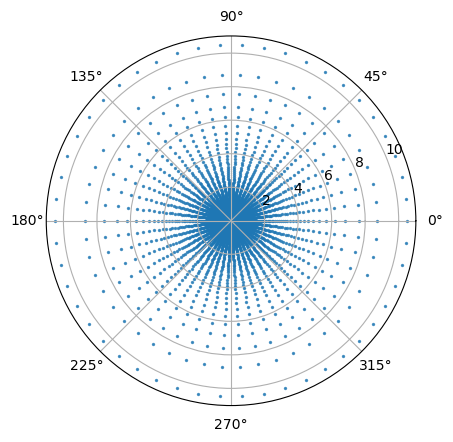

In [41]:
def make_grid_Iweighted(nr, nphi, outerr, Re, n):
    bn_val = f_bn(n)
    g2n = special.gamma(2*n)

    gamma2 = special.gammainc(2*n, outerr**(1/n) * Re**(-1/n) * bn_val)

    u = np.linspace(0, 1, nr)
    r = Re * (special.gammaincinv(2*n, u * gamma2) / bn_val)**n
    phi = np.linspace(0, 2*np.pi, nphi+1)[:-1]

    return np.meshgrid(r, phi)

r, phi = make_grid_Iweighted(100, 50, np.max(np.abs(survey_region.bounding_box.extent)), Re_fid, n_fid)

ax = plt.gcf().add_subplot(111, projection='polar')
ax.scatter(phi, r, s=2, alpha=.75)

In [42]:
nr = 100
nphi = 100
region = survey_region
Re = Re_fid
n = n_fid
Ie = Ie_fid

outerr = np.max(np.abs(region.bounding_box.extent))
outer_integ = sersic_integral(outerr, Re, n)

r, phi = make_grid_Iweighted(nr, nphi, outerr, Re, n)
_, _, msk = grid_in_region(r, phi, region)
fracingrid = np.sum(msk)/msk.size

result = outer_integ * fracingrid

result

np.float64(16.022939952215232)

  0%|          | 0/11 [00:00<?, ?it/s]

(10, 30) t 1.49e-04 +/- 5.76e-05, frac: 38.805% Ideviation: -3.846%
(30, 10) t 1.45e-04 +/- 1.91e-05, frac: 13.148% Ideviation: -2.159%
(10, 100) t 2.45e-04 +/- 1.40e-04, frac: 56.941% Ideviation: -4.352%
(100, 10) t 2.53e-04 +/- 1.28e-05, frac: 5.051% Ideviation: -0.556%
(100, 100) t 1.56e-03 +/- 4.53e-05, frac: 2.899% Ideviation: -0.354%
(500, 100) t 7.45e-03 +/- 1.07e-03, frac: 14.294% Ideviation: -0.058%
(100, 500) t 6.71e-03 +/- 3.22e-04, frac: 4.804% Ideviation: -0.399%
(1000, 1000) t 1.33e-01 +/- 5.10e-03, frac: 3.830% Ideviation: -0.039%
(500, 10) t 8.12e-04 +/- 1.61e-04, frac: 19.863% Ideviation: -0.151%
(1000, 10) t 1.60e-03 +/- 1.24e-04, frac: 7.777% Ideviation: -0.113%
(1000, 100) t 1.31e-02 +/- 2.01e-04, frac: 1.540% Ideviation: -0.034%
(10, 30) frac in mask: 76.00%
(30, 10) frac in mask: 77.33%
(10, 100) frac in mask: 75.60%
(100, 10) frac in mask: 78.60%
(100, 100) frac in mask: 78.76%
(500, 100) frac in mask: 78.99%
(100, 500) frac in mask: 78.72%
(1000, 1000) frac in m

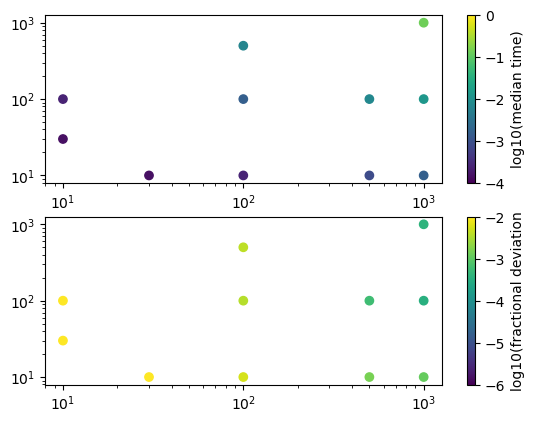

In [43]:
times = []
medtimes = []
stdtimes = []
results = []
fracinmasks = []
for nr, nphi in tqdm(nrnphi_to_try):
    reses = []
    ts = []
    for _ in range(timing_repeats):
        t1 = time.time()

        outerr = np.max(np.abs(survey_region.bounding_box.extent))
        outer_integ = sersic_integral(outerr, Re_fid, n_fid)

        r, phi = make_grid_Iweighted(nr, nphi, outerr, Re_fid, n_fid)
        _, _, msk = grid_in_region(r, phi, region)
        fracingrid = np.sum(msk)/msk.size

        result = outer_integ * fracingrid

        t2 = time.time()

        reses.append(result)
        ts.append(t2-t1)
    fracinmasks.append(fracingrid)

    times.append(ts)
    medtimes.append(np.median(ts))
    stdtimes.append(np.std(ts))

    # confirm that there's no significant variation in the results at 1e-7 level
    assert np.std(reses)/np.mean(reses) < 1e-7, f'{nr},{nphi} {np.std(reses)} {np.mean(reses)} {np.array(reses)}'
    
    results.append(np.mean(reses))

fracdev = (np.array(results) - directresult[0])/directresult[0]

fig, (ax1, ax2) = plt.subplots(2, 1)

sc = ax1.scatter(*np.array(nrnphi_to_try).T, c=np.log10(medtimes), vmin=-4, vmax=0)
plt.colorbar(sc, ax=ax1).set_label('log10(median time)')

sc = ax2.scatter(*np.array(nrnphi_to_try).T, c=np.log10(np.abs(fracdev)), vmin=-6, vmax=-2)
plt.colorbar(sc, ax=ax2).set_label('log10(fractional deviation')

for ax in [ax1, ax2]:
    ax.loglog()


for nl, t, s, f in zip(nrnphi_to_try, medtimes, stdtimes, fracdev):
    print(nl, 't', f'{t:.2e} +/- {s:.2e}, frac: {s/t:.3%}', 'Ideviation:', f'{f:.3%}')

for nl, fi in zip(nrnphi_to_try, fracinmasks):
    print(nl, 'frac in mask:', f'{fi:.2%}')

# Conclusion

* Speeds are pretty close to the same for nearly all cases at similar data sizes.  Probably dominated by RNG or something?
* T2 seems to be the quickest converging. Not clear if that's true for highly elliptical cases, though.

Next step: repeat except with a much more elongated box (which mocks up a highly ellptical region). See notebook generated below

* For elongated box, hard to do better than ~1%, but the only viable options seem to be T2 and T5, and T5 converges far faster.


So best solution would seem to be T5 at ~100 x 100

We now re-write this notebook itself, clearing outputs, and removing everything from the conclusion on.

In [44]:
import nbformat

In [45]:
nb = nbformat.read('sersic_integral_experiments.ipynb', nbformat.NO_CONVERT)

# clear outputs
for c in nb.cells:
    if c.cell_type == 'code':
        c.outputs = []
        c.execution_count = None

ccells = [i for i,c in enumerate(nb.cells) if c.source.startswith('# Conclusion')]
assert len(ccells) == 1

del nb.cells[ccells[0]:]


In [46]:
pcells = [c for c in nb.cells if c.source.startswith('# PARAMS:')]
assert len(pcells) == 1
pcell = pcells[0]
pcell.source = """
# PARAMS: survey
survey_lowerx = -2
survey_upperx = 2
survey_lowery = -40
survey_uppery1 = 50
survey_uppery2 = 90
"""[1:-1]

In [47]:
with open('sersic_integral_experiments_elongated.ipynb', 'w') as f:
    nbformat.write(nb, f)